PyTorch practice with MNIST data

WNixalo - 2018/2/27

---

## 0. Imports

In [11]:
# %reload_ext autoreload
# %autoreload 2
%matplotlib inline

In [1]:
import torch
import torchvision

import numpy as np

# import mnist_loader

In [2]:
# train, valid, test = mnist_loader.load_data(path='data/mnist/')

## 1. Data Loading

In [2]:
# torchvision datasets are PIL.Image images of range [0,1]. Must trsfm them 
# to Tensors of normalized range [-1,1]
transform = torchvision.transforms.Compose(
    [torchvision.transforms.ToTensor(),
     torchvision.transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))]
)
# I have no idea how this works

In [76]:
trainset = torchvision.datasets.MNIST(root='./data/mnist/', train=True,
                                      download=True, transform=transform)
testset  = torchvision.datasets.MNIST(root='./data/mnnist/', train=False, 
                                      download=False, transform=transform)
# ^ already downloaded w/ trainset; doesnt need to be `download=True`

trainloader = torch.utils.data.DataLoader(trainset, batch_size=32, 
                                          shuffle=True, num_workers=4)
testloader  = torch.utils.data.DataLoader(testset, batch_size=32, 
                                          shuffle=False, num_workers=4)

Processing...
Done!


In [4]:
classes = tuple(str(i+1) for i in range(10))
classes

('1', '2', '3', '4', '5', '6', '7', '8', '9', '10')

## 2. Network Definition

In [118]:
class FullNet(torch.nn.Module):
    def __init__(self, layers):
        super().__init__()
        self.layers = torch.nn.ModuleList([
            torch.nn.Linear(layers[i], layers[i+1]) for i in range(len(layers) - 1)
        ])
    def forward(self, x):
        x = x.view(x.size(0), -1)
        for layer in self.layers:
            layer_x = layer(x)
            x = torch.nn.functional.relu(layer_x) # NOTE we dont use relu as last actvn
        return torch.nn.functional.log_softmax(layer_x, dim=-1) # but we DO take the last layer's output

In [119]:
layers = [1*28*28, 40, 10] # MNIST dims: torch.Size([1, 28, 28]
network = FullNet(layers)

In [120]:
network

FullNet(
  (layers): ModuleList(
    (0): Linear(in_features=784, out_features=40, bias=True)
    (1): Linear(in_features=40, out_features=10, bias=True)
  )
)

In [121]:
[param.numel() for param in network.parameters()]

[31360, 40, 400, 10]

## 3. Loss Function & Optimizer Definitions

In [122]:
# loss function
criterion = torch.nn.CrossEntropyLoss()
# backprop optimizer
optimizer = torch.optim.SGD(network.parameters(), lr=1e-2, momentum=0.9)

In [123]:
network.parameters

<bound method Module.parameters of FullNet(
  (layers): ModuleList(
    (0): Linear(in_features=784, out_features=40, bias=True)
    (1): Linear(in_features=40, out_features=10, bias=True)
  )
)>

## 4. Training

---

**Aside:** example training one minibatch

In [124]:
trainloader

In [203]:
# I don't know how to get just one minibatch out of trainloader but this works
for i, data in enumerate(trainloader):
    if i == 0:
        inp, lab = data
        inp, lab = (torch.autograd.Variable(x) for x in (inp,lab))
        
outp = network(inp)
loss = criterion(outp, lab)

In [213]:
for elm in (loss.data, loss.data[0]): print(elm)


 2.3698
[torch.FloatTensor of size 1]

2.3697829246520996


---

In [125]:
# some help from: 
# http://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html#train-the-network
for epoch in range(2):
    running_loss = 0.0
    for i, data in enumerate(trainloader, start=0):
        # get inputs & wrap them in Variable
        inputs, labels = data
        inputs, labels = torch.autograd.Variable(inputs), torch.autograd.Variable(labels)
        
        # zero the parameter gradients
        optimizer.zero_grad()
        
        # forward + backward + optimize
        outputs = network(inputs)             # forward computation step
        loss    = criterion(outputs, labels)  # loss calculation
        loss.backward()                       # backward (backprop) comp.step (gradient calculations)
        optimizer.step()                      # SGD step: update weights
        
        # print statistics
        running_loss += loss.data[0]
        if i % 200 == 199: # print every 200 mini-batches
            print(f'{[epoch+1, i+1]} loss: {running_loss/2000}')
            
print(f'Training Loop Complete')

[1, 200] loss: 0.08223918932676315
[1, 400] loss: 0.12379545839503407
[1, 600] loss: 0.16112342023104428
[1, 800] loss: 0.19378408048674464
[1, 1000] loss: 0.22447118280082942
[1, 1200] loss: 0.25460694983974097
[1, 1400] loss: 0.2821106288600713
[1, 1600] loss: 0.30961359589546916
[1, 1800] loss: 0.33626045821607115
[2, 200] loss: 0.021724706136621533
[2, 400] loss: 0.04294103889167309
[2, 600] loss: 0.06436645950842648
[2, 800] loss: 0.08606091195857152
[2, 1000] loss: 0.1072557271947153
[2, 1200] loss: 0.12731340752681716
[2, 1400] loss: 0.14723177703144028
[2, 1600] loss: 0.16624242612766102
[2, 1800] loss: 0.18413627829542384
Training Loop Complete


**NOTE**: forgot to divide running loss by 200, not 2000.

## 5. Visualizing Data

In [242]:
# help from:
# http://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html#test-the-network-on-the-test-data

# oh so can you just wrap the DataLoader in `iter()` and get elements that way? ahhh..
dataiter = iter(testloader)
images, labels = dataiter.next()

In [368]:
# images

In [245]:
def imshow(img):
    img = img / 2 + 0.5 # unnormalize
    npimg = img.numpy()
    try:
        plt.imshow(np.transpose(npimg, (1, 2, 0)))
    except NameError:
        import matplotlib.pyplot as plt  # not sure if Py3.6 supports condtl imports..
        plt.imshow(np.transpose(npimg, (1, 2, 0)))

    7   2   1   0   4   1   4   9
    5   9   0   6   9   0   1   5
    9   7   3   4   9   6   6   5
    4   0   7   4   0   1   3   1


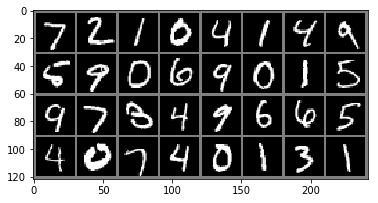

In [374]:
imshow(torchvision.utils.make_grid(images))
for i in range(len(labels)//8):
    print('  ' + ' '.join(f'{labels[i*8 + j]:3d}' for j in range(8)))
# print(f'Ground Truth: '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

*okay, that's actually so cool.*

---

**Aside:** figuring out why the labels were printed wrong (corrected now)

In [367]:
# original
[[labels[i+j] for j in range(8)] for i in range(4)]

[[7, 2, 1, 0, 4, 1, 4, 9],
 [2, 1, 0, 4, 1, 4, 9, 5],
 [1, 0, 4, 1, 4, 9, 5, 9],
 [0, 4, 1, 4, 9, 5, 9, 0]]

In [365]:
# corrected
[[labels[i*8 + j] for j in range(8)] for i in range(4)]

[[7, 2, 1, 0, 4, 1, 4, 9],
 [5, 9, 0, 6, 9, 0, 1, 5],
 [9, 7, 3, 4, 9, 6, 6, 5],
 [4, 0, 7, 4, 0, 1, 3, 1]]

Making sure the images match up with their corresponding labels:

In [349]:
img = images[8]
img = img / 2 + 0.5
img = img.numpy()
img = np.transpose(img, (1,2,0))
img.shape

(28, 28, 1)

(28, 28)


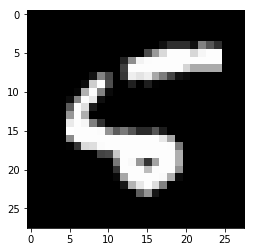

In [362]:
print(img[:,:,0].shape)
plt.imshow(img[:,:,0],cmap='gray');

In [363]:
labels[8]

5

---

**Aside:** understanding some matrix stuff for images

In [333]:
img = torchvision.utils.make_grid(images)
img = img / 2 + 0.5
img = img.numpy()   # (3, 122, 242)
# plt.imshow(np.transpose(img, (1, 2, 0)))  # (122, 242, 3)
# plt.imshow(np.transpose(img, (0, 1, 2)))  # (3, 122, 242) ## invalid dims
# plt.imshow(np.transpose(img, (0, 1, 2))[0])  # (122, 242) ## this works instead

# So, plt needs HxWxC, but will work with CxHxW iff C=1
# Our images from DataLoader are CxHxW
# Can use img = np.transpose(img, (1,2,0)) to convert CxHxW --> HxWxC

(122, 242)

In [334]:
img = images[-1]
img = torchvision.utils.make_grid(img)
print(img.shape)
print(np.transpose(img, (1,2,0)).shape)

torch.Size([3, 28, 28])
torch.Size([28, 28, 3])


(1, 28, 28)


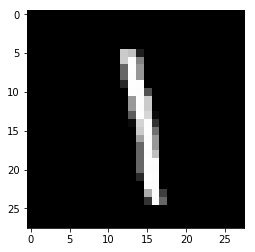

In [335]:
img = images[-1]
img = img / 2 + 0.5
img = img.numpy()
# img = np.transpose(img, (1,2,0))
# img.shape
plt.imshow(img[0], cmap='gray') # see: https://matplotlib.org/examples/color/colormaps_reference.html
print(img.shape)

Having trouble now with 1 channel images in `pyplot`. 3 channel HxWxC is fine for 1 channel, HxW is fine, but both CxHxW and HxWxC fail if C = 1.

---

## 7. Testing

### 7.1 Test Run on Single MiniBatch

In [375]:
# test run on first minibatch:
dataiter = iter(testloader)
images, labels = dataiter.next()

outputs = network(torch.autograd.Variable(images))

# btw, it seems getting further into iterators is where itertools comes in:
# https://stackoverflow.com/a/3267069

Sanity Check: output of neuralnet for 1 minibatch of 32 images for 10 classes is a $32 \times 10$ tensor.

In [377]:
outputs.shape

torch.Size([32, 10])

And the `images` object being wrapped as a pytorch Variable & sent into the network is itself a `torch.FloatTensor` -- to answer the question of *how do I get data into a PyTorch neuralnet again?*

`type(images)` --> `torch.FloatTensor`; coming out of `dataiter.next()` which itself is `iter(testloader)` which defined in §1.

In [384]:
_, predicted = torch.max(outputs.data, 1)

# output tensor is 32x10. That's 32 rows of values in 10 columns.
# torch.max(outputs.data, 1) specifies finding maximum value along axis-1 (ie: columnwise)
# torch.max(..) returns: (value, index)

0.9375


[[7, 2, 1, 0, 4, 1, 4, 9],
 [6, 9, 0, 6, 9, 0, 1, 3],
 [9, 7, 3, 4, 9, 6, 6, 5],
 [4, 0, 7, 4, 0, 1, 3, 1]]

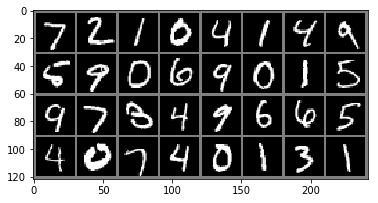

In [391]:
imshow(torchvision.utils.make_grid(images))
# accuracy:
print(sum(labels == predicted)/len(labels)) # sum of torch.ByteTensor size 32
# predictions:
[[predicted[i*8 + j] for j in range(8)] for i in range(4)]


$93.75\%$ accuracy, though this is a notoriously easy dataset.

### 7.2 Testing on full test dataset

In [403]:
correct = 0
total = 0

for datum in testloader:
    images, labels  = datum
    outputs = network(torch.autograd.Variable(images))
    _, predicted = torch.max(outputs.data, 1)
    
    total += labels.size(0)  # labels.size() --> torch.Size([size])
    correct += (predicted == labels).sum()  # method of torch.ByteTensor

print(f'MNIST dataset accuracy: {100*np.round(correct/total, 4)}%\n{total} images.')

MNIST dataset accuracy: 94.38%
10000 images.


Awesome.

## 8 Custom Data

In [13]:
import cv2
import os

In [14]:
flist = os.listdir('data/digits/')
flist = ['data/digits/' + f for f in flist]

In [15]:
flist.remove('data/digits/digits.png')

In [16]:
flist

['data/digits/pen1-9.png',
 'data/digits/pen1-8.png',
 'data/digits/pen2-8.png',
 'data/digits/pen2-9.png',
 'data/digits/pen2-0.png',
 'data/digits/pen1-5.png',
 'data/digits/pencil-2.png',
 'data/digits/pencil-3.png',
 'data/digits/pen1-7a.png',
 'data/digits/pen1-4.png',
 'data/digits/pen1-6.png',
 'data/digits/pencil-1.png',
 'data/digits/pencil-0.png',
 'data/digits/pen1-7b.png',
 'data/digits/pen1-3.png',
 'data/digits/pencil-4.png',
 'data/digits/pencil-5.png',
 'data/digits/pen1-2.png',
 'data/digits/pen1-0.png',
 'data/digits/pencil-6.png',
 'data/digits/pen1-1.png']

In [318]:
custom_labels = [f.split('-')[-1].split('.')[0] for f in flist]
# remove 'a' & 'b'
for i,elm in enumerate(custom_labels):
    if len(elm) > 1:
        custom_labels[i] = custom_labels[i][0]
custom_labels = [int(λ) for λ in custom_labels]

# labels should be of type: [torch.LongTensor of size 16] size acc. to num labels
custom_labels = torch.Tensor(custom_labels)  # I think this'll do

In [319]:
images = [cv2.imread(f) for f in flist]

# reference for what datatype images will be:
# [torch.FloatTensor of size 16x1x28x28] --- last minibatch: 10000 % 32 = 16

# array of images from disk
images = [cv2.imread(f) for f in flist]

# resize images to 28x28
images = [cv2.resize(img, (28,28), interpolation=cv2.INTER_AREA) for img in images]

# convert 3-channel png to Grayscale (opencv loads as bgr)
images = [cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) for img in images]

# invert grayscale (to be in line w/ MNIST data)
images = [255 - img for img in images]

# convert HxW dims to HxWxC for PyTorch usage later
images = [np.expand_dims(img, -1) for img in images]

## NOTE: need remove last dim to view in pyplot.imshow via: images[idx][:,:,0]

In [68]:
## another way to do resizings
# get transformation foreach image (x,y : c,r)
# trsfs = [[28/img.shape[1], 28/img.shape[0]] for img in images]
# img = cv2.resize(img, None, fx=28/img.shape[1], fy=28/img.shape[0], interpolation=cv2.INTER_AREA)

In [207]:
## create PyTorch dataset class
# from: http://pytorch.org/tutorials/beginner/data_loading_tutorial.html#dataset-class
class custom_dataset(torch.utils.data.Dataset):
    def __init__(self, data_array, transform=None): # going to want to put inputs&labels in as zipped tuples
        self.data = data_array
        self.transform=transform
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        """Return a dict of image & label"""
        image = self.data[idx][0]
        label = self.data[idx][1]
        
        if self.transform:
            image = self.transform(image) # wait, does this alter self.data[idx][0] ??
    
#         return {'image':image, 'label':label} ## I don't see key names in PT MNIST loader
        return (image, label)

In [320]:
## create dataloader
transform = torchvision.transforms.Compose(
    [torchvision.transforms.ToTensor(),
     torchvision.transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))]
)

custom_data = custom_dataset(list(zip(images, custom_labels)), transform=transform)

custom_dataloader = torch.utils.data.DataLoader(custom_data, batch_size=32,
                                                shuffle=False, num_workers=4)

In [322]:
## create batch-iterator of dataloader
custom_dataiter = iter(custom_dataloader)

In [235]:
## Test Network on Data
indata, labels  = custom_dataiter.next()
indata  = torch.autograd.Variable(indata)

outputs = network(indata)

In [236]:
_, predictions = torch.max(outputs, 1)

And here we see an immediate jumpy to ~ 81% accuracy on completely new images, thanks to preprocessing -- to make the images look like those the network trained on.

In [231]:
print('Y*  Y\'\n------')

correct = 0
for elem in zip(labels, predictions.data):
    correct += elem[0]==elem[1]
    print(int(elem[0]), ' ', elem[1])
    
print('------')

total   = len(labels)

print(f'A: {100*np.round((correct/total), 4)}%')


Y*  Y'
------
9   8
8   8
8   8
9   9
0   0
5   5
2   2
3   3
7   7
4   4
6   6
1   1
0   0
7   7
3   3
4   4
5   5
2   4
0   9
6   6
1   8
------
A: 80.95%


Predictions on images without preprocessing:

Predictions on my own hand-written digits. Zero accuracy, but understandable. This is a standard Linear Neural Net. It's nodes are looking for specific numbers in the input tensor, they're not really capable of spotting spatial features. I expect accuracy to get back to 'normal', ~90% range, after I preprocess to invert black/white.

In [237]:
print('Y*  Y\'\n------')

correct = 0
for elem in zip(labels, predictions.data):
    correct += elem[0]==elem[1]
    print(int(elem[0]), ' ', elem[1])
    
print('------')

total   = len(labels)

print(f'A: {100*np.round((correct/total), 4)}%')

Y*  Y'
------
9   2
8   7
8   2
9   2
0   3
5   2
2   7
3   7
7   2
4   2
6   7
1   2
0   3
7   0
3   5
4   3
5   2
2   3
0   5
6   2
1   2
------
A: 0.0%


Well that was super cool. The Linear/Fully-Connected/Dense Neural Net on it's own is very limited. It can't recognize spatially-correlated features. Maybe it can, but it's ability  to do is ephemeral and a byproduct at best. I can do better with a simple ConvNet.

## 9. Simple ConvNet

In [301]:
class ConvNet(torch.nn.Module):
    def __init__(self, layers, c):
        super().__init__()
        self.layers = torch.nn.ModuleList([
            torch.nn.Conv2d(layers[i], layers[i+1], kernel_size=3, stride=2) 
            for i in range(len(layers) - 1)
        ])
#         self.pool = nn.AdaptiveMaxPool2d(1)             # can use this to pool
        self.out = torch.nn.Linear(layers[-1], c)
    
    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        x = torch.nn.functional.adaptive_avg_pool2d(x, 1) # or this to pool
        x = x.view(x.size(0), -1)
        return torch.nn.functional.log_softmax(self.out(x), dim=-1)

In [328]:
class ConvNetMod(torch.nn.Module):
    """'Modern' ConvNet using large-field input conv layer"""
    def __init__(self, layers, c):
        super().__init__()
        # 'modern' large-field input Conv layer
        self.conv1 = torch.nn.Conv2d(1,10,kernel_size=5, stride=1, padding=2)
        # Conv block
        self.layers = torch.nn.ModuleList([
            torch.nn.Conv2d(layers[i], layers[i+1], kernel_size=3, stride=2) 
            for i in range(len(layers) - 1)
        ])
        # output classification Linear layer
        self.out = torch.nn.Linear(layers[-1], c)
        
    def forward(self, x):
        x = self.conv1(x)
        for layer in self.layers:   # conv layers in convblock
            x = layer(x)
        x = torch.nn.functional.adaptive_max_pool2d(x, 1) # pool after conv block
        x = x.view(x.size(0), -1)                         # reshape final featmap to vector
        return torch.nn.functional.log_softmax(self.out(x), dim=-1) # apply output nonlinearity on final outputs

### 9.1 Train ConvNet & ConvNetMod:

Is it valid to put put the optimizer and criterion inside the network object? Yeah, right? If I set `loss = convnetwork.criterion(outputs, labels)`, then `loss.backward()` that'll update the loss *within* the network object yeah?

$\Longrightarrow$ nah wasn't working the way I had it implemented.

**NOTE**: lol.. it trains 2x ~ 4x as fast if I correctly set the stride to 2 (had it to 1 at first). Yeah ofc.

**ConvNet**:

In [310]:
layers = [1, 20, 40, 80] # this may be too much -- filter size by last layer is ..? 7? 3.5?
c = 10

convnetwork = ConvNet(layers, c)

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(convnetwork.parameters(), lr=0.01, momentum=0.9)

num_epochs = 2

for epoch in range(num_epochs):
    running_loss = 0.0
    
    for i, datum in enumerate(trainloader):
        inputs, labels = datum
        inputs, labels = torch.autograd.Variable(inputs), torch.autograd.Variable(labels)
        
        optimizer.zero_grad()
        
        outputs = convnetwork(inputs)
        loss    = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
#         print(f'minibatch no. {i+1}  Loss: {loss.data[0]/(i+1)}')
        
        running_loss += loss.data[0]
        if i % 200 == 199: # print every 200 mini-batches
            print(f'{[epoch+1, i+1]} loss: {running_loss/200}')
            running_loss = 0.0
            
print(f'Training Loop Complete')

[1, 200] loss: 1.5147740623354913
[1, 400] loss: 0.8907962292432785
[1, 600] loss: 0.7682120184600353
[1, 800] loss: 0.7408229354023933
[1, 1000] loss: 0.6852227079868317
[1, 1200] loss: 0.6981311133503914
[1, 1400] loss: 0.6829375706613063
[1, 1600] loss: 0.6524065189063549
[1, 1800] loss: 0.6446917968988418
[2, 200] loss: 0.6353790518641472
[2, 400] loss: 0.6347182787954807
[2, 600] loss: 0.6338051172345877
[2, 800] loss: 0.6304291028529405
[2, 1000] loss: 0.6218855299800634
[2, 1200] loss: 0.6026327655464411
[2, 1400] loss: 0.5834794988483191
[2, 1600] loss: 0.6285126277059316
[2, 1800] loss: 0.6001350527256727
Training Loop Complete


That loss is about 1/3 what I got with the same training regimen on a Linear network.

More training:

In [331]:
num_epochs = 2

for epoch in range(num_epochs):
    running_loss = 0.0
    
    for i, datum in enumerate(trainloader):
        inputs, labels = datum
        inputs, labels = torch.autograd.Variable(inputs), torch.autograd.Variable(labels)
        
        optimizer.zero_grad()
        
        outputs = convnetwork(inputs)
        loss    = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
#         print(f'minibatch no. {i+1}  Loss: {loss.data[0]/(i+1)}')
        
        running_loss += loss.data[0]
        if i % 200 == 199: # print every 200 mini-batches
            print(f'{[epoch+1, i+1]} loss: {running_loss/200}')
            running_loss = 0.0
            
print(f'Training Loop Complete')

[1, 200] loss: 0.5811036449670791
[1, 400] loss: 0.5610083170980215
[1, 600] loss: 0.6128740479052067
[1, 800] loss: 0.6100998826324939
[1, 1000] loss: 0.6341160758584737
[1, 1200] loss: 0.5942814573645592
[1, 1400] loss: 0.594333580210805
[1, 1600] loss: 0.6236286294460297
[1, 1800] loss: 0.595114980712533
[2, 200] loss: 0.576330739185214
[2, 400] loss: 0.5908198317885399
[2, 600] loss: 0.6049356714636087
[2, 800] loss: 0.5888264106214046
[2, 1000] loss: 0.5759006731957197
[2, 1200] loss: 0.6162133126705885
[2, 1400] loss: 0.5872442109882832
[2, 1600] loss: 0.5917398457229137
[2, 1800] loss: 0.5769337169080972
Training Loop Complete


In [335]:
optimizer = torch.optim.SGD(convnetwork.parameters(), lr=0.005, momentum=0.9)

num_epochs = 2

for epoch in range(num_epochs):
    running_loss = 0.0
    
    for i, datum in enumerate(trainloader):
        inputs, labels = datum
        inputs, labels = torch.autograd.Variable(inputs), torch.autograd.Variable(labels)
        
        optimizer.zero_grad()
        
        outputs = convnetwork(inputs)
        loss    = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
#         print(f'minibatch no. {i+1}  Loss: {loss.data[0]/(i+1)}')
        
        running_loss += loss.data[0]
        if i % 200 == 199: # print every 200 mini-batches
            print(f'{[epoch+1, i+1]} loss: {running_loss/200}')
            running_loss = 0.0
            
print(f'Training Loop Complete')

[1, 200] loss: 0.5499874053150415
[1, 400] loss: 0.5505127182602882
[1, 600] loss: 0.5441986237466335
[1, 800] loss: 0.5343618736043573
[1, 1000] loss: 0.5295614355057477
[1, 1200] loss: 0.5584205207228661
[1, 1400] loss: 0.5378603199124337
[1, 1600] loss: 0.5592815712094307
[1, 1800] loss: 0.5127506905794144
[2, 200] loss: 0.5422512035816908
[2, 400] loss: 0.5255283830314874
[2, 600] loss: 0.5359036011993885
[2, 800] loss: 0.549936011210084
[2, 1000] loss: 0.5385399685800075
[2, 1200] loss: 0.5557142957299948
[2, 1400] loss: 0.5206742455810308
[2, 1600] loss: 0.5254877541959285
[2, 1800] loss: 0.5394602462649345
Training Loop Complete


**ConvNetMod**:

This wasn't training the first time. I think at 6 layers I'm too deep to effectively train, especially with that large first layer. Maybe it would work better if I used batch norm. Also, I wonder if the benefit of the large initial receptive field is mitigated by the tiny and relatively simple images.

Oh.. it's because I set the optimizer to `optimizer = torch.optim.SGD(convnetwork.parameters(), ...)` It was optimizing for the wrong network architecture.

In [336]:
layers = [10, 20, 40, 80] # this may be too much -- filter size by last layer is ..? 7? 3.5?
c = 10

convnetworkmod = ConvNetMod(layers, c)

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(convnetworkmod.parameters(), lr=0.01, momentum=0.9)

num_epochs = 2

for epoch in range(num_epochs):
    running_loss = 0.0
    
    for i, datum in enumerate(trainloader):
        inputs, labels = datum
        inputs, labels = torch.autograd.Variable(inputs), torch.autograd.Variable(labels)
        
        optimizer.zero_grad()
        
        outputs = convnetworkmod(inputs)
        loss    = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
#         print(f'minibatch no. {i+1}  Loss: {loss.data[0]/(i+1)}')
        
        running_loss += loss.data[0]
        if i % 200 == 199: # print every 200 mini-batches
            print(f'{[epoch+1, i+1]} loss: {running_loss/200}')
            running_loss = 0.0
            
print(f'Training Loop Complete')

[1, 200] loss: 0.9755856948718429
[1, 400] loss: 0.36350536564365027
[1, 600] loss: 0.2829720405489206
[1, 800] loss: 0.25728355629369615
[1, 1000] loss: 0.2428307731356472
[1, 1200] loss: 0.22951006439514457
[1, 1400] loss: 0.2248263764567673
[1, 1600] loss: 0.19917273157509044
[1, 1800] loss: 0.19325778452679515
[2, 200] loss: 0.17952732898760587
[2, 400] loss: 0.17119824059773237
[2, 600] loss: 0.16161648735869677
[2, 800] loss: 0.172478382284753
[2, 1000] loss: 0.17300547419581563
[2, 1200] loss: 0.1848725085519254
[2, 1400] loss: 0.169392710684333
[2, 1600] loss: 0.1442504899809137
[2, 1800] loss: 0.15615285632607992
Training Loop Complete


*Wow*, nevermind. Introducing the large-receptive-field conv layer in the beginning *really* helped with the loss.

### 9.2 Test accuracy of ConvNets

In [317]:
correct = 0
total   = 0

for datum in testloader:
    inputs, labels = datum
    inputs         = torch.autograd.Variable(inputs)
    
    outputs = convnetwork(inputs)
    _, predictions = torch.max(outputs.data, 1)
    
    total += labels.size(0)
    correct += (labels == predictions).sum()
    
print(f'MNIST dataset accuracy: {100*np.round(correct/total, 4)}%\n{total} images.')

MNIST dataset accuracy: 80.91000000000001%
10000 images.


*technically* less accurate, but I know it has a lot more potential than the other method, and will be more resilient.

---

**Aside:** checking how I can access the number of elements in a minibatch via labels:

In [313]:
labels.size(0)

32

In [314]:
torch.autograd.Variable(labels).size(0)

32

In [315]:
len(labels)

32

In [316]:
len(torch.autograd.Variable(labels))

32

---

### 9.3 Run ConvNets on custom data;

In [ ]:
## NOTE: make sure the custom_dataloader from §8 is in memory

ConvNet after 4 epochs at lr=0.01 and 2 epochs at lr=0.05:

In [337]:
## create batch-iterator of dataloader
custom_dataiter = iter(custom_dataloader)

indata, labels  = custom_dataiter.next()
indata  = torch.autograd.Variable(indata)

outputs = convnetwork(indata)

_, predictions = torch.max(outputs, 1)


print('Y*  Y\'\n------')

correct = 0
for elem in zip(labels, predictions.data):
    correct += elem[0]==elem[1]
    print(int(elem[0]), ' ', elem[1])
    
print('------')

total   = len(labels)

print(f'A: {100*np.round((correct/total), 4)}%')


Y*  Y'
------
9   3
8   8
8   8
9   9
0   0
5   5
2   2
3   3
7   7
4   7
6   6
1   1
0   0
7   7
3   3
4   7
5   5
2   2
0   7
6   5
1   1
------
A: 76.19%


ConvNetMod after 2 epochs of training:

In [338]:
custom_dataiter = iter(custom_dataloader)

indata, labels  = custom_dataiter.next()
indata  = torch.autograd.Variable(indata)

outputs = convnetworkmod(indata)

_, predictions = torch.max(outputs, 1)


print('Y*  Y\'\n------')

correct = 0
for elem in zip(labels, predictions.data):
    correct += elem[0]==elem[1]
    print(int(elem[0]), ' ', elem[1])
    
print('------')

total   = len(labels)

print(f'A: {100*np.round((correct/total), 4)}%')

Y*  Y'
------
9   2
8   8
8   8
9   9
0   0
5   5
2   2
3   3
7   7
4   4
6   6
1   1
0   0
7   4
3   3
4   4
5   5
2   2
0   9
6   6
1   1
------
A: 85.71%


In [349]:
def viewimg(image_array, idx):
    image = image_array[idx]
    image = image[:,:,0]
    image = image/2 + 0.5
    image = 255 - image
    plt.imshow(image, cmap='gray')

Convnet's prediction: 2


(None, None)

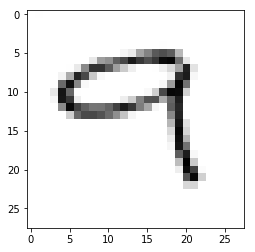

In [351]:
idx =0
viewimg(images, idx), print(f'Convnet\'s prediction: {predictions.data[idx]}')

Convnet's prediction: 8


(None, None)

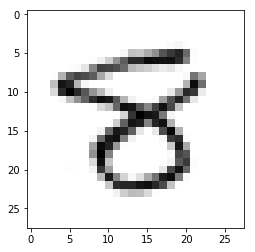

In [352]:
idx =1
viewimg(images, idx), print(f'Convnet\'s prediction: {predictions.data[idx]}')

Convnet's prediction: 0


(None, None)

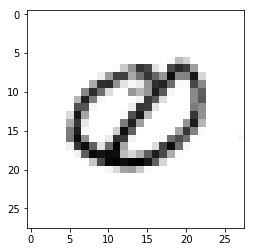

In [357]:
idx =4
viewimg(images, idx), print(f'Convnet\'s prediction: {predictions.data[idx]}')

Convnet's prediction: 2


(None, None)

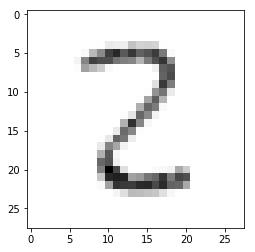

In [358]:
idx =6
viewimg(images, idx), print(f'Convnet\'s prediction: {predictions.data[idx]}')

Convnet's prediction: 1


(None, None)

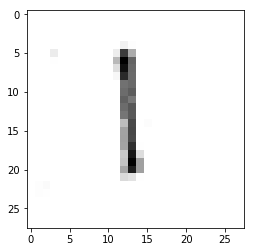

In [359]:
idx =20
viewimg(images, idx), print(f'Convnet\'s prediction: {predictions.data[idx]}')

Convnet's prediction: 4


(None, None)

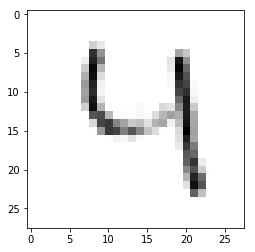

In [360]:
idx =15
viewimg(images, idx), print(f'Convnet\'s prediction: {predictions.data[idx]}')

Convnet's prediction: 6


(None, None)

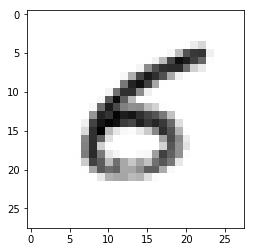

In [361]:
idx =19
viewimg(images, idx), print(f'Convnet\'s prediction: {predictions.data[idx]}')

Convnet's prediction: 7


(None, None)

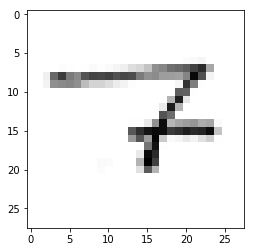

In [368]:
idx =8
viewimg(images, idx), print(f'Convnet\'s prediction: {predictions.data[idx]}')

---

**Aside:** Checking that my custom data iterator works exactly the same as the PT MNIST one:

In [369]:
# custom_dataiter.next()

In [333]:
# dataiter = iter(testloader)

In [370]:
# dataiter.next()

Although I wonder if I should have preprocessed my written digits to be color inverted. I see a lot of `-1`'s in the PT MNIST data, and `+1`'s in my own. They're both normalized in range $[-1,1]$, making me think that's the case. Luckily it's a simple NumPy or OpenCV operation away, and can just be done in the initial image-loading phase.

I may do so without updating this Aside.

---

## Z. Misc

---

**Aside:** Getting the DataLoader to work:

In [87]:
custom_dataiter.next()

ValueError: Traceback (most recent call last):
  File "/Users/WayNoxchi/Miniconda3/envs/fastai/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 55, in _worker_loop
    samples = collate_fn([dataset[i] for i in batch_indices])
  File "/Users/WayNoxchi/Miniconda3/envs/fastai/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 55, in <listcomp>
    samples = collate_fn([dataset[i] for i in batch_indices])
  File "<ipython-input-76-0debf74882c5>", line 17, in __getitem__
    image = self.transform(image) # wait, does this alter self.data[idx][0] ??
  File "/Users/WayNoxchi/Miniconda3/envs/fastai/lib/python3.6/site-packages/torchvision-0.2.0-py3.6.egg/torchvision/transforms/transforms.py", line 42, in __call__
    img = t(img)
  File "/Users/WayNoxchi/Miniconda3/envs/fastai/lib/python3.6/site-packages/torchvision-0.2.0-py3.6.egg/torchvision/transforms/transforms.py", line 61, in __call__
    return F.to_tensor(pic)
  File "/Users/WayNoxchi/Miniconda3/envs/fastai/lib/python3.6/site-packages/torchvision-0.2.0-py3.6.egg/torchvision/transforms/functional.py", line 48, in to_tensor
    img = torch.from_numpy(pic.transpose((2, 0, 1)))
ValueError: axes don't match array


In [89]:
img = images[0]

In [92]:
torch.from_numpy(img.transpose((2,0,1)))

ValueError: axes don't match array

In [96]:
np.expand_dims(img, -1).shape

(28, 28, 1)

In [97]:
torch.from_numpy(np.expand_dims(img,-1).transpose((2,0,1)))


(0 ,.,.) = 

Columns 0 to 14 
   255  254  255  255  255  255  255  255  255  255  255  255  255  255  255
  255  255  255  255  255  255  255  255  255  255  255  255  255  255  255
  255  255  255  255  255  255  255  255  255  255  255  255  255  255  255
  255  255  255  255  255  255  255  255  255  255  255  255  255  255  255
  255  255  255  255  255  255  255  255  255  255  255  255  255  255  255
  255  255  255  255  255  255  255  255  255  255  255  255  245  235  170
  255  255  255  255  255  255  255  255  233  165  153  108   86   44   72
  255  255  255  255  255  254  234  146   68   68  103  165  207  240  255
  255  255  255  255  244  177   52   88  205  249  255  255  255  255  255
  255  255  255  253  116   34  145  249  255  255  255  255  255  255  255
  255  255  255  232   39  114  254  255  255  255  255  255  255  255  255
  255  255  255  246   41   70  239  255  255  255  255  255  239  209  139
  255  255  255  255  148   28   80  110  127  126  112 

Okay, that looks like my problem. The images inside ... ahhhh... okay. Far as I can tell, here's what's up:

My images from the dataset are failing to load (ie: the dataloader is failing to retrieve images from the dataset) because they're failing a NumPy transpose operation. PyTorch is looking for MxCxHxW Tensors (M=minibatch), and the assumption is images (I think) will be in HxWxC format $\longrightarrow$ so they get transformed to CxHxW. Issue is my images have only HxW dimensions so this operation fails.

But it looks like if I provide the image in the right format, the transpose operation returns the correct-looking formatted image. Cool.

Why the *ahh*?  Well inside the MNIST dataset class: `torchvision.datasets.mnist`, there's a delineation between 'raw' and 'processed' images. The data for MNIST is first downloaded, but they arrive as compressed `.gz` files. These are then unzipped into a `raw` folder, then saved to a `processed` folder. I don't know if PyTorch does its image preprocessing on the images when they are saved to `processed` or after they're retreived. Anyway, when you pull an item from the dataset, internally it goes and retrieves it from the `processed` folder, or it initalizes the data array in memory from that folder (unsure which).

In [ ]:
test

In [83]:
# custom_data.data[0]

In [81]:
custom_dataiter = iter(custom_data)

In [82]:
custom_dataiter.next()

AttributeError: 'iterator' object has no attribute 'next'

In [47]:
type(custom_data.data[0][0])

numpy.ndarray

In [35]:
a = [i for i in range(6)]
b = [chr(ord('a')+i) for i in range(6)]
c = list(zip(a,b))
c

[(0, 'a'), (1, 'b'), (2, 'c'), (3, 'd'), (4, 'e'), (5, 'f')]

In [28]:
ord('a')

97

In [74]:
torchvision.datasets.mnist??

In [72]:
trainset

In [84]:
# trainset[0]

In [2]:
# torchvision datasets are PIL.Image images of range [0,1]. Must trsfm them 
# to Tensors of normalized range [-1,1]
transform = torchvision.transforms.Compose(
    [torchvision.transforms.ToTensor(),
     torchvision.transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))]
)
# I have no idea how this works

In [76]:
trainset = torchvision.datasets.MNIST(root='./data/mnist/', train=True,
                                      download=True, transform=transform)
testset  = torchvision.datasets.MNIST(root='./data/mnnist/', train=False, 
                                      download=False, transform=transform)
# ^ already downloaded w/ trainset; doesnt need to be `download=True`

trainloader = torch.utils.data.DataLoader(trainset, batch_size=32, 
                                          shuffle=True, num_workers=4)
testloader  = torch.utils.data.DataLoader(testset, batch_size=32, 
                                          shuffle=False, num_workers=4)

Processing...
Done!


In [521]:
images[0].dtype

dtype('uint8')

In [522]:
img = images[0]
img = np.expand_dims(img, -1)
img.shape

(28, 28, 1)

In [523]:
# compatibility for torchvision.transforms.Compose() -- expects NumPy ndarrays to be of 
# shape: HxWxC as acc to error:
#      46     if isinstance(pic, np.ndarray):
#      47         # handle numpy array
# ---> 48         img = torch.from_numpy(pic.transpose((2, 0, 1))
images = [np.expand_dims(img, -1) for img in images] # cvt (28,28) --> (28,28,1)
images = [transform(img) for img in images]



In [524]:
custom_loader = torch.utils.data.dataloader.DataLoader((images,custom_labels),
                                    batch_size=32,shuffle=False, num_workers=4)

In [548]:
# testset.test_data

In [525]:
images[0]


(0 ,.,.) = 

Columns 0 to 8 
   1.0000  0.9922  1.0000  1.0000  1.0000  1.0000  1.0000  1.0000  1.0000
  1.0000  1.0000  1.0000  1.0000  1.0000  1.0000  1.0000  1.0000  1.0000
  1.0000  1.0000  1.0000  1.0000  1.0000  1.0000  1.0000  1.0000  1.0000
  1.0000  1.0000  1.0000  1.0000  1.0000  1.0000  1.0000  1.0000  1.0000
  1.0000  1.0000  1.0000  1.0000  1.0000  1.0000  1.0000  1.0000  1.0000
  1.0000  1.0000  1.0000  1.0000  1.0000  1.0000  1.0000  1.0000  1.0000
  1.0000  1.0000  1.0000  1.0000  1.0000  1.0000  1.0000  1.0000  0.8275
  1.0000  1.0000  1.0000  1.0000  1.0000  0.9922  0.8353  0.1451 -0.4667
  1.0000  1.0000  1.0000  1.0000  0.9137  0.3882 -0.5922 -0.3098  0.6078
  1.0000  1.0000  1.0000  0.9843 -0.0902 -0.7333  0.1373  0.9529  1.0000
  1.0000  1.0000  1.0000  0.8196 -0.6941 -0.1059  0.9922  1.0000  1.0000
  1.0000  1.0000  1.0000  0.9294 -0.6784 -0.4510  0.8745  1.0000  1.0000
  1.0000  1.0000  1.0000  1.0000  0.1608 -0.7804 -0.3725 -0.1373 -0.0039
  1.0000  1.0000  1.

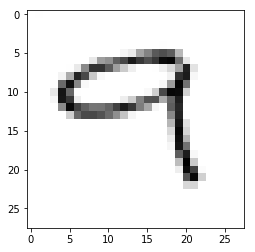

In [544]:
img = images[0]
img = img / 2 + 0.5
img = img.numpy()
# img = np.transpose(img, (1,2,0))
plt.imshow(img[0], cmap='gray')

In [536]:
y = network(torch.autograd.Variable(images[0]))

In [545]:
y

Variable containing:

Columns 0 to 7 
 -7.5255  -3.7893  -0.5199  -1.9057 -15.0865  -1.8598  -6.6464  -2.5998

Columns 8 to 9 
 -6.1027 -15.6800
[torch.FloatTensor of size 1x10]

In [538]:
torch.max(y, 1)

(Variable containing:
 -0.5199
 [torch.FloatTensor of size 1], Variable containing:
  2
 [torch.LongTensor of size 1])

In [517]:
dataiter = iter(testloader)
images, labels = dataiter.next()

In [526]:
x = dataiter.next()

In [371]:
# x[0][0]

list

In [492]:
testloader

In [493]:
testset

In [372]:
# custom_labels

In [467]:
custom_labels[0]

3458764513820540928

In [445]:
custom_dataset = 

(28, 28)

---

**Misc**:

In [43]:
for i, layer in enumerate(layers, start=0): # 2nd arg is index start count
    print(i, layer)

0 3072
1 40
2 10


In [48]:
len(trainloader)

1875

In [52]:
trainloader.batch_size

32

In [54]:
trainloader.dataset[0]

(<PIL.Image.Image image mode=L size=28x28 at 0x12D0CBD68>, 5)

In [64]:
trainloader.dataset[0][0]

In [65]:
trainloader.dataset[1][0]